# Multi-Armed Bandit (MAB) Demonstration

This notebook demonstrates how to use the MAB (Multi-Armed Bandit) algorithms in `causalml` for:
- Simulating bandit data
- Running classical and contextual bandit algorithms
- Evaluating and visualizing results

We will walk through each step with explanations and code.

## 1. Setup and Imports

First, let's import all the necessary libraries and define helper functions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from causalml.dataset import make_mab_data
from causalml.optimize.bandit import (
    EpsilonGreedy, UCB, ThompsonSampling, BatchBandit,
    LinUCB, CohortThompsonSampling, BatchLinUCB, BatchCohortThompsonSampling
)
from causalml.metrics import (
    cumulative_reward, cumulative_regret,
    plot_cumulative_reward, plot_cumulative_regret, plot_arm_selection_frequency
)

### Helper Functions

We define a helper function `run_online_bandit` that handles the online evaluation of different bandit algorithms.

In [2]:
def run_online_bandit(algo, X, arms, rewards, context_cols=None, cohort_col=None):
    """
    Run online evaluation of a bandit algorithm.
    
    Args:
        algo: Bandit algorithm instance
        X: Feature matrix
        arms: True arm assignments
        rewards: True rewards
        context_cols: Context columns (optional)
        cohort_col: Cohort column (optional)
    
    Returns:
        Tuple of (rewards_list, selected_arms)
    """
    rewards_list = []
    selected_arms = []
    for i in range(0, len(X), algo.batch_size):
        batch_X = X[i:i + algo.batch_size]
        batch_arms = arms[i:i + algo.batch_size]
        batch_rewards = rewards[i:i + algo.batch_size]
        if isinstance(algo, BatchLinUCB):
            chosen_arms = algo.select_arm(batch_X)
            rewards_batch = [r if a == b else 0 for a, b, r in zip(chosen_arms, batch_arms, batch_rewards)]
            algo.update_batch(np.array(chosen_arms), batch_X, np.array(rewards_batch))
            rewards_list.extend(rewards_batch)
            selected_arms.extend(chosen_arms)
        elif isinstance(algo, BatchCohortThompsonSampling):
            if cohort_col is not None and isinstance(cohort_col, (np.ndarray, list, pd.Series)):
                cohort_batch = cohort_col[i:i + algo.batch_size]
            else:
                cohort_batch = batch_X[:, 0]
            chosen_arms = algo.select_arm_batch(cohort_batch)
            rewards_batch = [r if a == b else 0 for a, b, r in zip(chosen_arms, batch_arms, batch_rewards)]
            algo.update_batch(cohort_batch, chosen_arms, rewards_batch)
            rewards_list.extend(rewards_batch)
            selected_arms.extend(chosen_arms)
        else:
            chosen_arms = algo.select_batch()
            rewards_batch = [r if a == b else 0 for a, b, r in zip(chosen_arms, batch_arms, batch_rewards)]
            algo.update_batch(chosen_arms, rewards_batch)
            rewards_list.extend(rewards_batch)
            selected_arms.extend(chosen_arms)
    return np.array(rewards_list), np.array(selected_arms)

## 2. Data Generation

We'll generate synthetic data for our bandit experiments. The data will include:
- One arm-specific feature for arm_1
- Different base reward rates for each arm
- Feature effects for arm_1

### Generate Feature Matrix and Rewards

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Data generation configuration
n_samples = 20000
coef_arm_dict = {'arm_1': [0.1]}  # One coefficient for arm_1's feature

# Create feature matrix
X = np.zeros((n_samples, 1))  # Only one feature for arm_1
X[:, 0] = np.random.normal(0, 1, n_samples)  # Random feature values

# Generate arm assignments and rewards
arms = np.random.choice(['arm_0', 'arm_1', 'arm_2', 'arm_3'], n_samples)
rewards = np.zeros(n_samples)

# Set base reward rates for each arm
base_rates = {
    'arm_0': 0.1,
    'arm_1': 0.08,
    'arm_2': 0.08,
    'arm_3': 0.06
}

# Generate rewards
for i in range(n_samples):
    arm = arms[i]
    if arm == 'arm_1':
        # Add feature effect for arm_1
        feature_effect = np.dot(X[i], coef_arm_dict['arm_1'])
        reward_prob = base_rates[arm] + feature_effect
    else:
        reward_prob = base_rates[arm]
    reward_prob = np.clip(reward_prob, 0, 1)  # Ensure valid probability
    rewards[i] = np.random.binomial(1, reward_prob)

### Data Statistics and Visualization

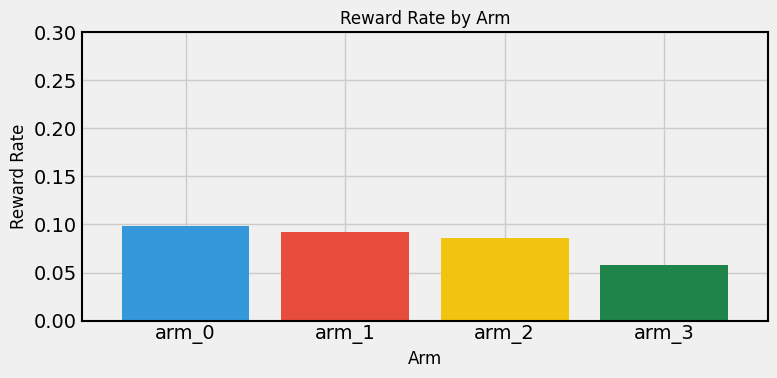

In [4]:
# Plot reward by arm
plt.figure(figsize=(8, 4))
arm_rewards = pd.DataFrame({'arm': arms, 'reward': rewards})
grouped = arm_rewards.groupby('arm')['reward'].mean()
grouped.plot(kind='bar', width=0.8, color=['#3498DB', '#E74C3C', '#F1C40F', '#1E8449'])

plt.title('Reward Rate by Arm', fontsize=12)
plt.xlabel('Arm', fontsize=12)
plt.ylabel('Reward Rate', fontsize=12)
plt.ylim([0,0.3])
plt.tick_params(axis='x', rotation=0)

# Apply a box to the plot
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()


Data Generation Statistics:
Total samples: 20000
Number of features: 1

Arm reward rates:
arm_0: 9.80%
arm_1: 9.26%
arm_2: 8.59%
arm_3: 5.77%


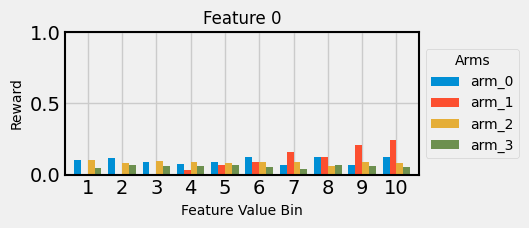

In [5]:
# Print data generation statistics
print("\nData Generation Statistics:")
print(f"Total samples: {n_samples}")
print(f"Number of features: {X.shape[1]}")
print("\nArm reward rates:")
for arm in np.unique(arms):
    rate = np.mean(rewards[arms == arm])
    print(f"{arm}: {rate:.2%}")

# Create feature name mapping for plots
feature_map = {f"feature_{i}": f"Feature {i}" for i in range(X.shape[1])}

# Plot reward by feature value and arm (bar chart grid)
n_bins = 10
n_cols = 3
n_rows = int(np.ceil(X.shape[1] / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 2.5 * n_rows), sharey=True)
axes = axes.flatten()

for i in range(X.shape[1]):
    feature = f"feature_{i}"
    df = pd.DataFrame({feature: X[:, i]})
    df['arm'] = arms
    df['reward'] = rewards
    df[f'{feature}_binned'] = pd.qcut(df[feature], q=n_bins, duplicates='drop').cat.codes + 1
    grouped = df.groupby([f'{feature}_binned', 'arm'])['reward'].mean().unstack()
    grouped.plot(kind='bar', ax=axes[i], width=0.8)
    axes[i].set_xlabel('Feature Value Bin', fontsize=10)
    axes[i].set_ylabel('Reward', fontsize=10)
    axes[i].set_title(f'{feature_map[feature]}', fontsize=12)
    axes[i].set_ylim([0, 1.])
    if i == X.shape[1] - 1:
        axes[i].legend(title='Arms', loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10, title_fontsize=10)
    else:
        axes[i].legend().set_visible(False)
    axes[i].tick_params(axis='x', rotation=0)
    for spine in axes[i].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)
    df.drop(columns=[f'{feature}_binned'], inplace=True)

# Remove any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()


### Prepare Cohort Information

In [6]:
# Add cohort information for cohort-based algorithms
df = pd.DataFrame({
    'arm': arms,
    'reward': rewards,
    'feature_0': X[:, 0]
})
df['cohort'] = np.random.choice([0, 1, 2], size=len(df))

# Show the first few rows
print("\nFirst few rows of the dataset:")
print(df.head())


First few rows of the dataset:
     arm  reward  feature_0  cohort
0  arm_3     0.0   0.496714       1
1  arm_0     1.0  -0.138264       1
2  arm_1     0.0   0.647689       2
3  arm_0     0.0   1.523030       0
4  arm_3     1.0  -0.234153       1


## 3. Initialize and Run Bandit Algorithms

We'll demonstrate both classical and contextual bandits. All bandits are fit using the consistent API.

In [7]:
# Get feature columns for contextual bandits
feature_cols = [f'feature_{i}' for i in range(X.shape[1])]

# Initialize and fit bandits to set up their internal state
# Classical bandits
eg = BatchBandit(EpsilonGreedy(epsilon=0.3), batch_size=100)
eg.fit(arms, rewards)

ucb = BatchBandit(UCB(alpha=1.0), batch_size=100)
ucb.fit(arms, rewards)

ts = BatchBandit(ThompsonSampling(), batch_size=100)
ts.fit(arms, rewards)

# Contextual bandits
linucb = BatchLinUCB(alpha=1.0, batch_size=100)
linucb.fit(X, arms, rewards)

# Bin the feature into 10 bins using pd.qcut
n_bins_mab = 10
feature_for_cohort = 0  # Only one feature, index 0
cohort_bins = pd.qcut(X[:, feature_for_cohort], n_bins_mab, labels=False, duplicates="drop")

# Use the binned cohort in the bandit
cohort_ts = BatchCohortThompsonSampling(batch_size=100)
cohort_ts.fit(X, arms, rewards, cohort_feature=cohort_bins)

## 5. Summary

In this notebook, we demonstrated:
1. How to generate synthetic bandit data with arm-specific features
2. How to initialize and run different bandit algorithms
3. How to evaluate and visualize the performance of each algorithm

The results show how different algorithms perform in terms of:
- Cumulative reward
- Cumulative regret
- Arm selection frequency

As results show, the Contextual MAB (LinUCB and Cohort Thompson Sampling) methods  outperform classic MAB when there is context influencing arm performance. 

You can modify the parameters and configurations to experiment with different scenarios.

## 5. Summary

In this notebook, we demonstrated:
1. How to generate synthetic bandit data with arm-specific features
2. How to initialize and run different bandit algorithms
3. How to evaluate and visualize the performance of each algorithm

The results show how different algorithms perform in terms of:
- Cumulative reward
- Cumulative regret
- Arm selection frequency

As results show, the Contextual MAB (LinUCB and Cohort Thompson Sampling) methods  outperform classic MAB when there is context influencing arm performance. 

You can modify the parameters and configurations to experiment with different scenarios.

### Run Online Evaluation

In [8]:
results = {}
results['BatchEpsilonGreedy'] = run_online_bandit(eg, X, arms, rewards)
results['BatchUCB'] = run_online_bandit(ucb, X, arms, rewards)
results['BatchThompsonSampling'] = run_online_bandit(ts, X, arms, rewards)
results['BatchLinUCB'] = run_online_bandit(linucb, X, arms, rewards)
results['BatchCohortThompsonSampling'] = run_online_bandit(cohort_ts, X, arms, rewards, cohort_col=cohort_bins)

# Print first 10 rewards and selected arms for each algorithm
for name, (rewards, selected_arms) in results.items():
    print(f"\n{name}:")
    print(f"First 10 rewards: {rewards[:10]}")
    print(f"First 10 selected arms: {selected_arms[:10]}")


BatchEpsilonGreedy:
First 10 rewards: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
First 10 selected arms: ['arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_1' 'arm_0' 'arm_0'
 'arm_0']

BatchUCB:
First 10 rewards: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
First 10 selected arms: ['arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0'
 'arm_0']

BatchThompsonSampling:
First 10 rewards: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
First 10 selected arms: ['arm_0' 'arm_1' 'arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0'
 'arm_0']

BatchLinUCB:
First 10 rewards: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
First 10 selected arms: ['arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0' 'arm_0'
 'arm_0']

BatchCohortThompsonSampling:
First 10 rewards: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
First 10 selected arms: ['arm_0' 'arm_1' 'arm_0' 'arm_3' 'arm_3' 'arm_3' 'arm_0' 'arm_3' 'arm_1'
 'arm_1']


## 4. Evaluate and Visualize Results

We'll create visualizations for:
1. Cumulative reward over time
2. Cumulative regret over time
3. Arm selection frequency

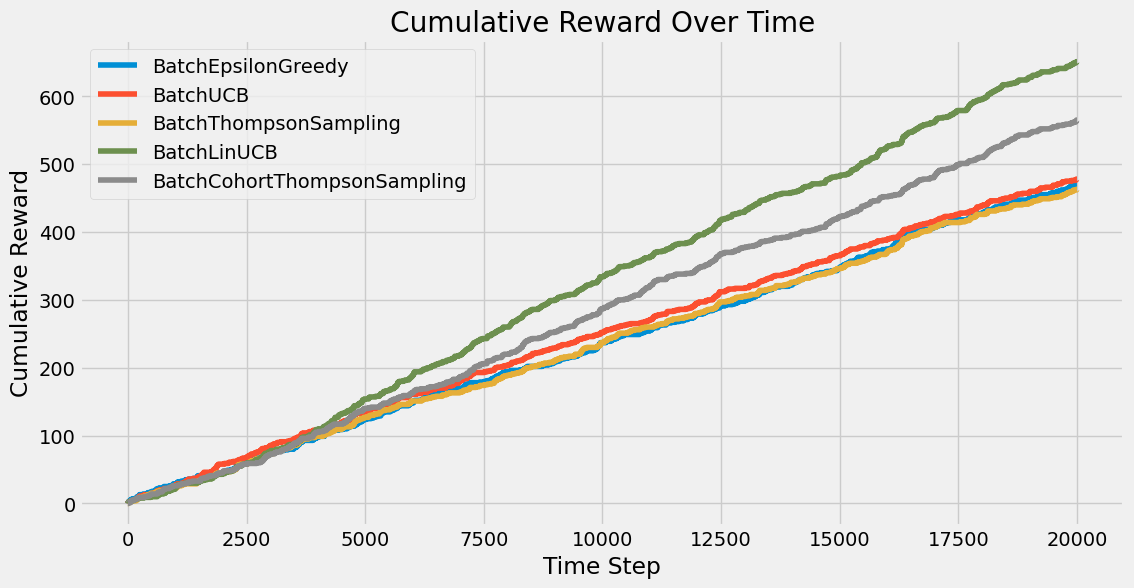

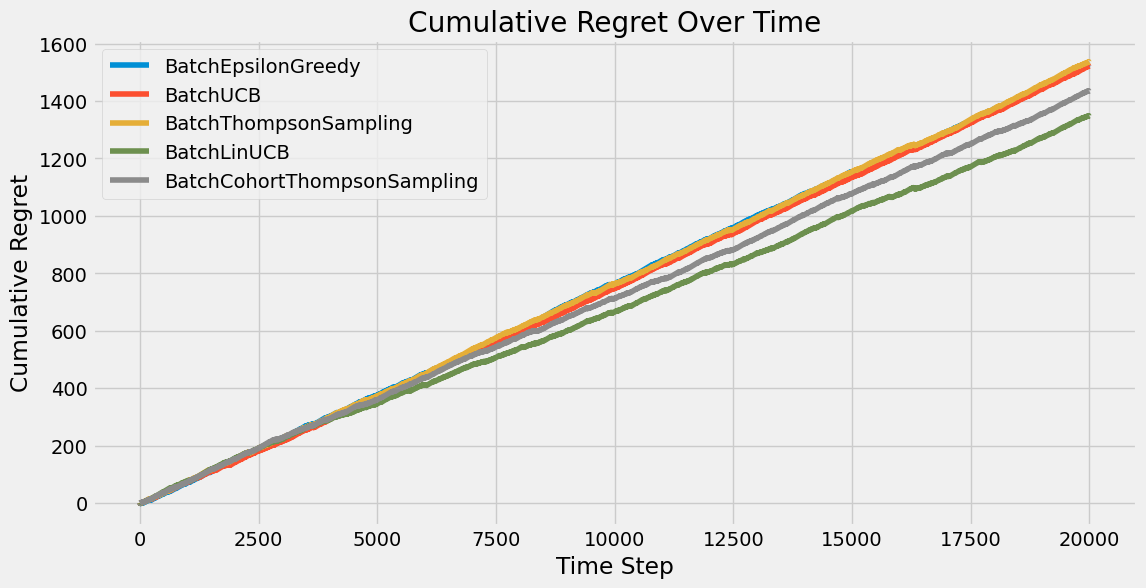

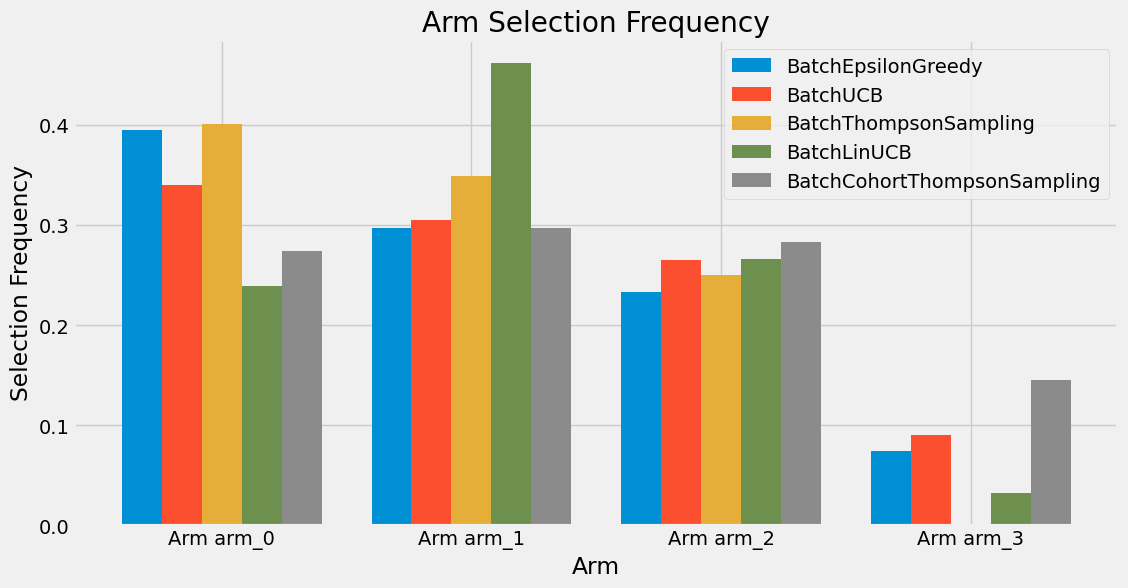

In [9]:
# Plot cumulative reward
plt.figure(figsize=(12, 6))
for name, (rewards, _) in results.items():
    cum_reward = cumulative_reward(rewards)
    plt.plot(cum_reward, label=name)
plt.title('Cumulative Reward Over Time')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)
plt.show()

# Plot cumulative regret
plt.figure(figsize=(12, 6))
# Calculate optimal reward based on our data generation configuration
# arm_0 has the highest base rate of 0.1
optimal_reward = 0.1  # This is the base rate of arm_0
for name, (rewards, _) in results.items():
    cum_regret = cumulative_regret(rewards, optimal_reward=optimal_reward)
    plt.plot(cum_regret, label=name)
plt.title('Cumulative Regret Over Time')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)
plt.show()

# Plot arm selection frequency
plt.figure(figsize=(12, 6))
n_methods = len(results)
bar_width = 0.8 / n_methods  # Adjust bar width based on number of methods

# Get all unique arms across all methods
all_arms = set()
for _, (_, selected_arms) in results.items():
    all_arms.update(selected_arms)
all_arms = sorted(list(all_arms))
x = np.arange(len(all_arms))

for i, (name, (_, selected_arms)) in enumerate(results.items()):
    arm_freq = pd.Series(selected_arms).value_counts(normalize=True)
    # Ensure we have frequencies for all arms, even if they weren't selected
    freq_values = [arm_freq.get(arm, 0) for arm in all_arms]
    plt.bar(x + i * bar_width, freq_values, width=bar_width, label=name)

plt.title('Arm Selection Frequency')
plt.xlabel('Arm')
plt.ylabel('Selection Frequency')
plt.xticks(x + bar_width * (n_methods - 1) / 2, [f'Arm {arm}' for arm in all_arms])
plt.legend()
plt.grid(True)
plt.show()

## 5. Summary

In this notebook, we demonstrated:
1. How to generate synthetic bandit data with arm-specific features
2. How to initialize and run different bandit algorithms
3. How to evaluate and visualize the performance of each algorithm

The results show how different algorithms perform in terms of:
- Cumulative reward
- Cumulative regret
- Arm selection frequency

As results show, the Contextual MAB (LinUCB and Cohort Thompson Sampling) methods  outperform classic MAB when there is context influencing arm performance. 

You can modify the parameters and configurations to experiment with different scenarios.

## 5. Summary

In this notebook, we demonstrated:
1. How to generate synthetic bandit data with arm-specific features
2. How to initialize and run different bandit algorithms
3. How to evaluate and visualize the performance of each algorithm

The results show how different algorithms perform in terms of:
- Cumulative reward
- Cumulative regret
- Arm selection frequency

As results show, the Contextual MAB (LinUCB and Cohort Thompson Sampling) methods  outperform classic MAB when there is context influencing arm performance. 

You can modify the parameters and configurations to experiment with different scenarios.